In [92]:
import pandas as pd
import numpy as np
import plotly.express
from sklearn.manifold import TSNE
import yfinance as yf
from gtda.time_series import embedding, TakensEmbedding
import matplotlib.pyplot as plt
import warnings
from pymssa import MSSA

warnings.filterwarnings('ignore')

In [80]:
stock = yf.download('AAPL', start='2022-01-01', end='2023-01-01')
electric_prod = pd.read_csv('./data/Electric_Production.csv')

[*********************100%%**********************]  1 of 1 completed


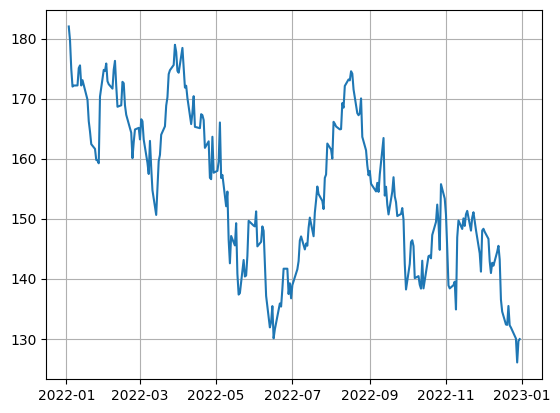

In [81]:
stock = stock.iloc[:1000]
stock = stock[['Close']]

electric_prod = electric_prod[['DATE', 'Value']]
electric_prod['DATE'] = pd.to_datetime(electric_prod['DATE'])
electric_prod = electric_prod.set_index('DATE')

plt.plot(stock)
plt.grid()

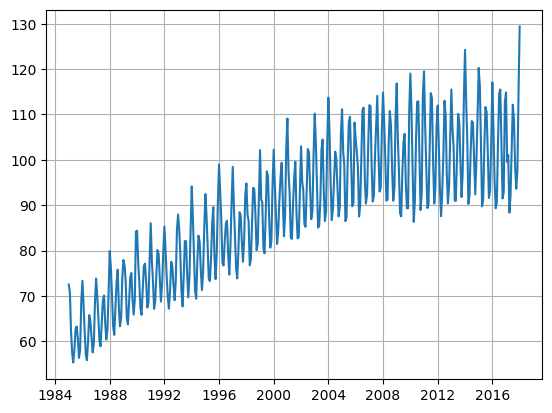

In [82]:
plt.plot(electric_prod)
plt.grid()

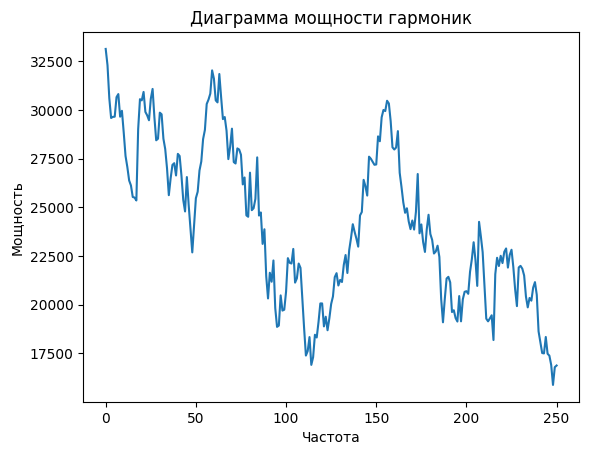

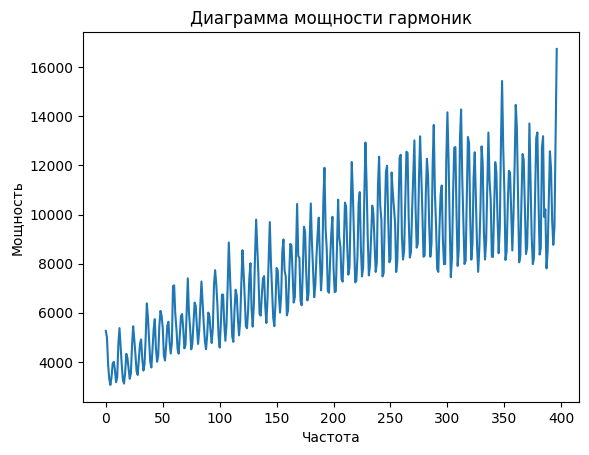

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка временных рядов
# Замените data_series на ваши временные ряды
for data in [stock, electric_prod]:
  data_series = data

  # Применение быстрого преобразования Фурье
  fft_result = np.fft.fft(data_series)

  # Вычисление мощности гармоник
  power_spectrum = np.abs(fft_result) ** 2

  # Создание диаграммы мощности гармоник
  plt.plot(power_spectrum)
  plt.title('Диаграмма мощности гармоник')
  plt.xlabel('Частота')
  plt.ylabel('Мощность')
  plt.show()

Constructing trajectory matrix
Trajectory matrix shape: (30, 222)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (30, 368)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


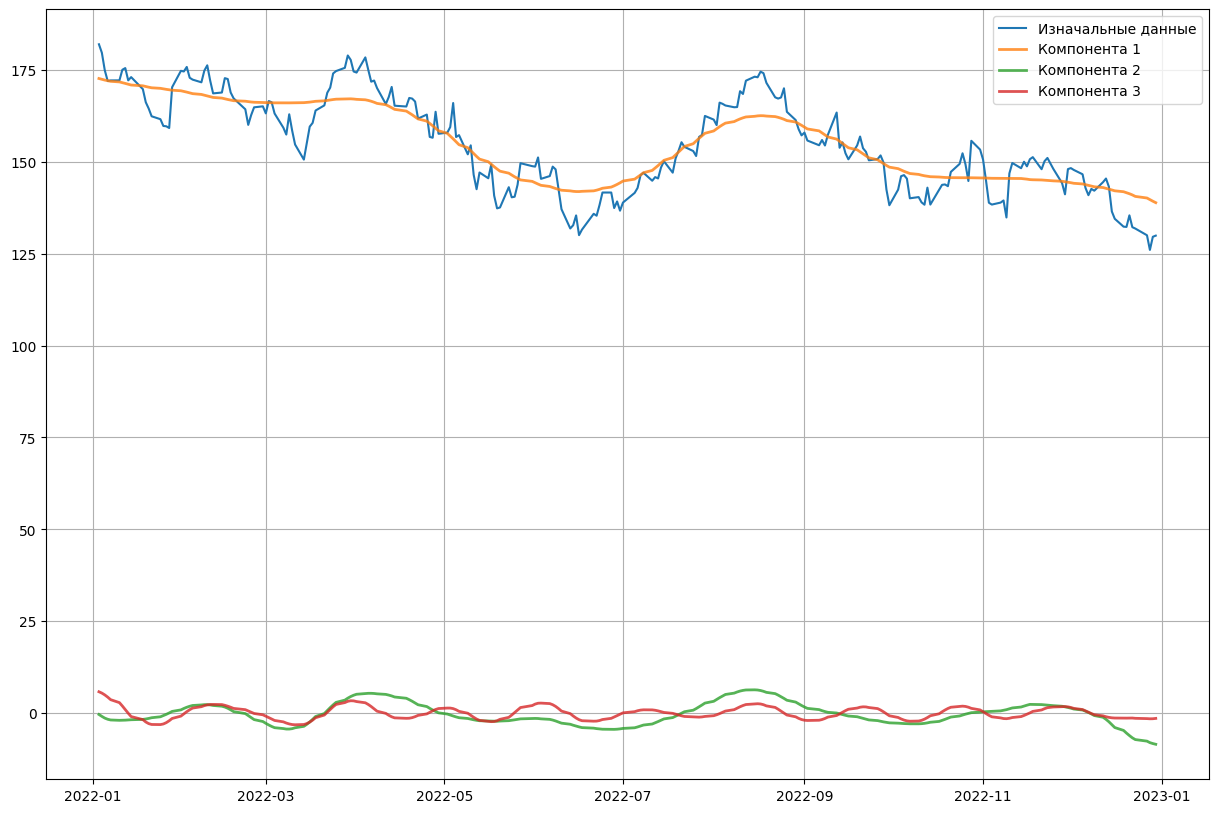

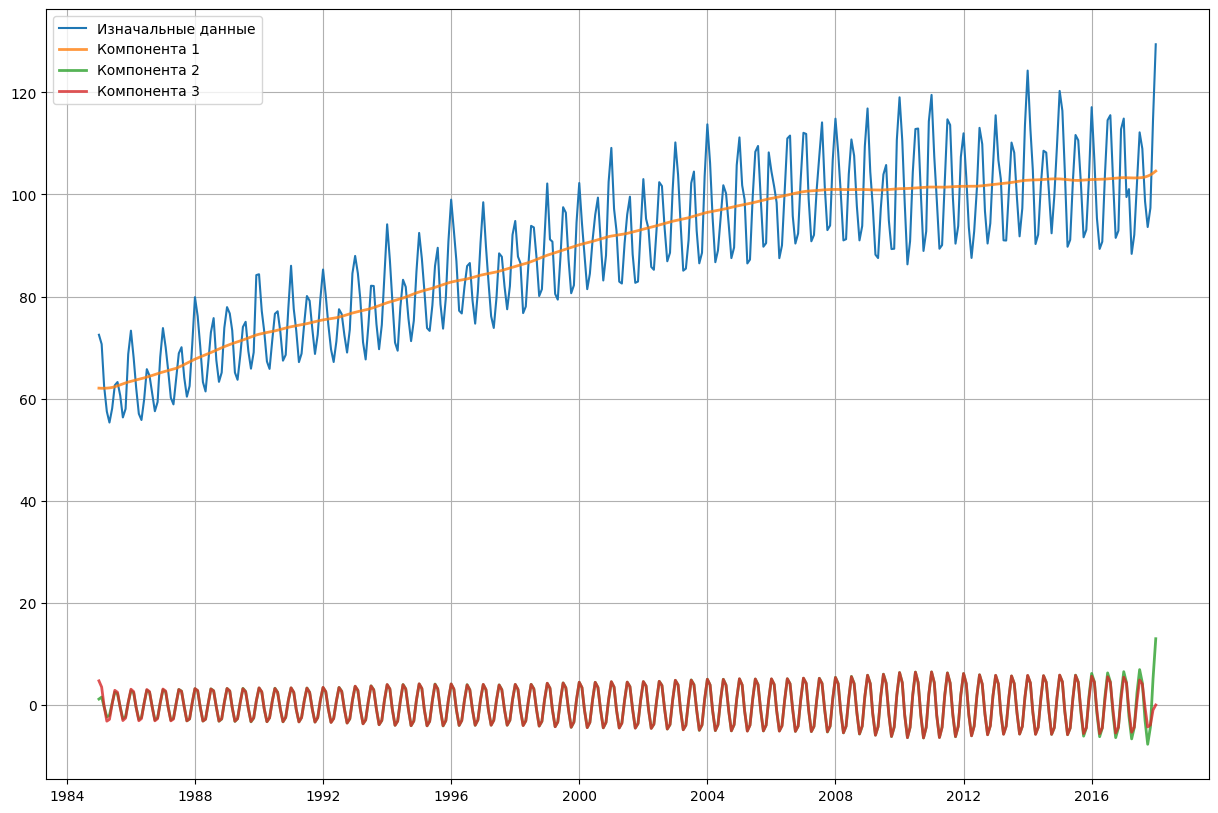

In [99]:
for data in [stock['Close'], electric_prod['Value']]:
  mssa = MSSA(n_components=3,
              window_size=30,
              verbose=True)
  x=data
  mssa.fit(x)

  fig=plt.figure(figsize=(15, 10))
  plt.plot(data, label='Изначальные данные')
  plt.grid()

  for idx in range(3):
      component = mssa.components_[0, :, idx]
      plt.plot(x.index, component, lw=2, alpha=0.8, label=f'Компонента {idx + 1}')

  plt.legend()

Constructing trajectory matrix
Trajectory matrix shape: (174, 176)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 22 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


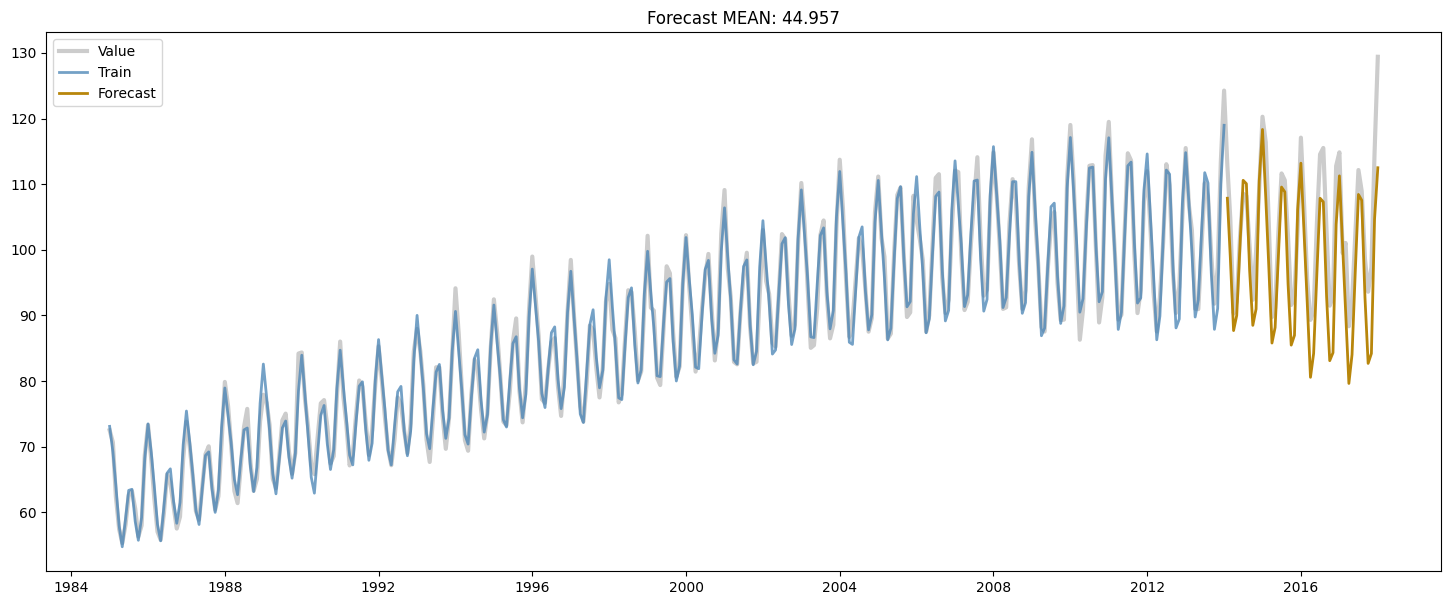

In [109]:
from sklearn.metrics import mean_squared_error

tp = 48
temp_te = electric_prod.iloc[-tp:]
temp_tr = electric_prod.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=temp_tr
mssa.fit(x)

for ts_index in range(electric_prod.shape[1]):
  tr = np.zeros(electric_prod.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = temp_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(electric_prod.index, electric_prod.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=electric_prod.columns[ts_index])
  ax.plot(electric_prod.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(electric_prod.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

Constructing trajectory matrix
Trajectory matrix shape: (101, 103)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 13 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


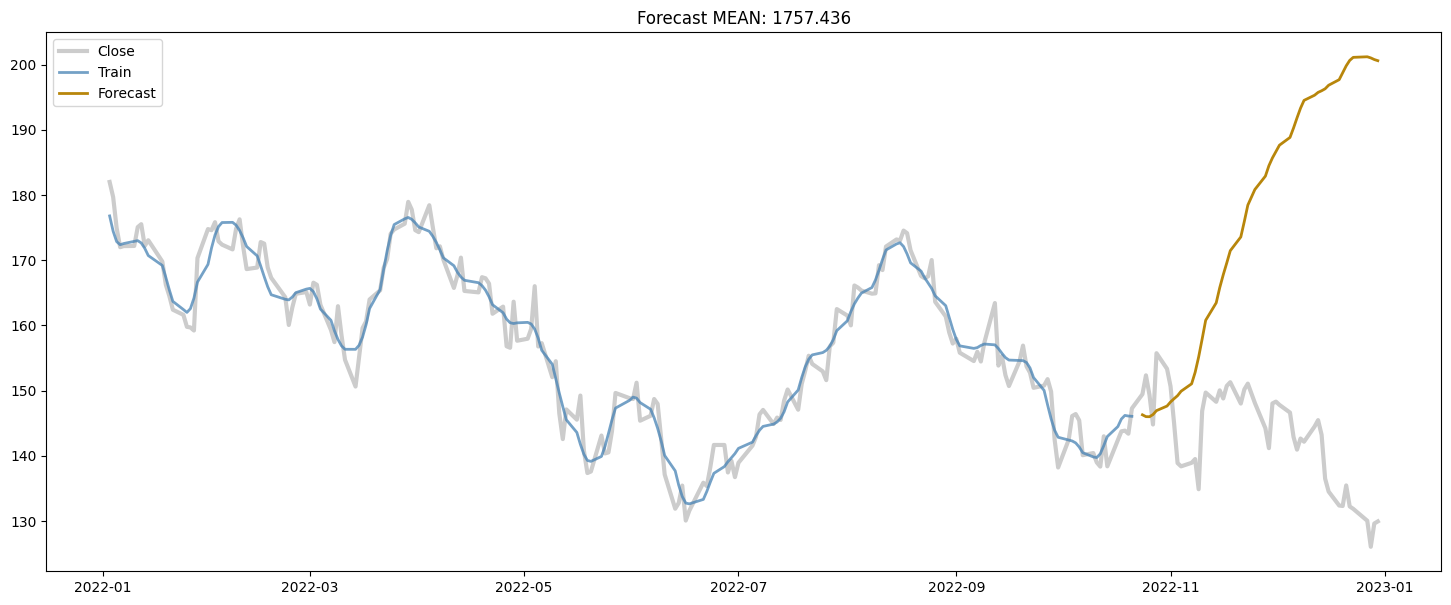

In [110]:
tp = 48
stock_te = stock.iloc[-tp:]
stock_tr = stock.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=stock_tr
mssa.fit(x)

for ts_index in range(stock.shape[1]):
  tr = np.zeros(stock.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = stock_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(stock.index, stock.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=stock.columns[ts_index])
  ax.plot(stock.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(stock.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

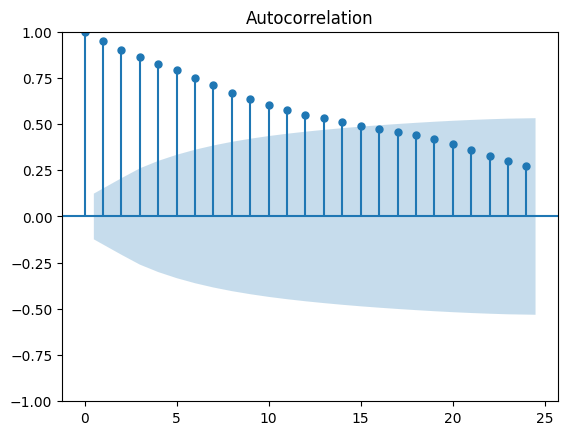

In [113]:
from statsmodels.graphics.tsaplots import plot_acf

# график автокорреляционной функции
plot_acf(stock['Close'].values)
plt.show()

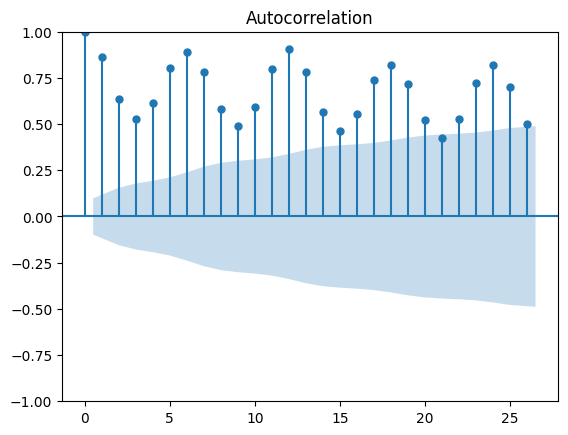

In [114]:
# Построение графика автокорреляционной функции
plot_acf(electric_prod['Value'].values)
plt.show()